In [3]:
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Cubic B-Spline interpolation with equidistant knots


In [36]:
def basis_function(t):
    t_ = np.array([1, t, t**2, t**3])
    feature_matrix = 1/6* np.array([[1, 4, 1, 0],
                               [-3,0 ,3,0],
                                 [3,-6,3,0],
                                 [-1,3,-3,1]])
    
    return t_ @ feature_matrix


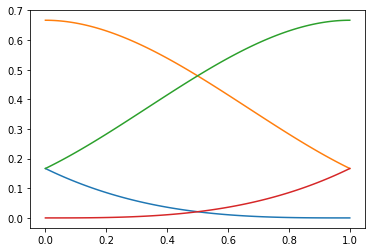

In [37]:
ts = np.linspace(0, 1, 100)
basis = np.zeros((100, 4))
for i, t in enumerate(ts):
    basis[i] = basis_function(t)

plt.plot(ts, basis[:,0], label="Basis 0")
plt.plot(ts, basis[:,1], label="Basis 1")
plt.plot(ts, basis[:,2], label="Basis 2")
plt.plot(ts, basis[:,3], label="Basis 3")


In [77]:
# vectorize the basis function
def basis_function_mat(ts, n_control_points, n_knots):
    mat = np.zeros((ts.shape[0], n_control_points))
    for i, t in enumerate(ts):
        offset = max(min(int(np.floor(t)), n_knots -1),0)
        u = t - offset
        mat[i][offset: offset + 4] = basis_function(u)
    
    return mat


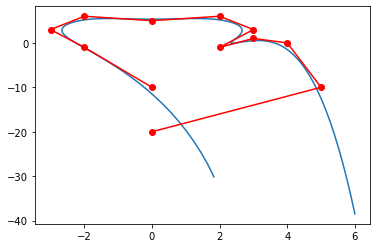

In [78]:
control_points = np.array([[0,-10], [-2,-1], [-3,3],[-2,6], [0,5], [2,6], [3,3], [2,-1], [3,1], [4,0], [5,-10], [0,-20]])
knots = [0,1,2,3,4,5,6,7]

curve = np.zeros((100, 2))
ts = np.linspace(-2, 10, 100)

basis = basis_function_mat(ts,12, 8)
curve = basis @ control_points


plt.plot(curve[:,0], curve[:,1], label="B-spline curve")
plt.plot(control_points[:,0], control_points[:,1], "ro-")


In [79]:
# Casadi Function for B-spline
def spline_eval(control_points, num_samples):
    n_knots = control_points.shape[0] - 4

    ts = np.linspace(0, n_knots, num_samples)
    basis = basis_function_mat(ts, control_points.shape[0], n_knots)
    curve = basis @ control_points

    return curve



Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      302
        inequality constraints with only lower bounds:      300
   inequality constraints with lower and upper bounds:        2
        inequality constraints with only upper bounds:        0


Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objective...............:   2.0849627798511925e+00    2.0849627798511925e+00
Dual infeasibility......:   5.1321732464720826e-04    5.1321732464720826e-04
Constraint violation....:   1.2935667173780141e-05    1.2935667173780141e-05
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

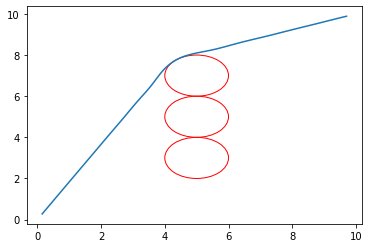

In [94]:
import casadi as cas

# Decision variables
n_control_points = 20
n_knots = n_control_points - 4
control_points = cas.SX.sym("control_points", n_control_points, 2)
dec_vars = cas.vertcat(cas.vec(control_points))


# Define Curve points with respect to control points and basis functions
curve = spline_eval(control_points, 100)

# Define constraints
start_point = np.array([0, 0])
end_point = np.array([10, 10])

cons = cas.SX([])
lbg = []
ubg = []

cons = cas.vertcat(cons, (curve[0,0] - start_point[0]) ** 2 + (curve[0,1] - start_point[1]) ** 2)
lbg = np.concatenate((lbg, [0]))
ubg = np.concatenate((ubg, [0.1]))

cons = cas.vertcat(cons, (curve[-1,0] - end_point[0]) ** 2 + (curve[-1,1] - end_point[1]) ** 2)
lbg = np.concatenate((lbg, [0]))
ubg = np.concatenate((ubg, [0.1]))

# Define Obstacle constraint
obstacle_positions = np.array([[5, 5], [5, 7], [5,3]])
obstacle_radii = np.array([1, 1,1])
for i in range(100):
    for obstacle_position, obstacle_radius in zip(obstacle_positions, obstacle_radii):
        cons = cas.vertcat(cons, (curve[i,0] - obstacle_position[0]) ** 2 + (curve[i,1] - obstacle_position[1]) ** 2 - obstacle_radius ** 2)
        lbg = np.concatenate((lbg, [0]))
        ubg = np.concatenate((ubg, [cas.inf]))

# Define cost function to minimize the length of the B-spline curve
cost = 0
for i in range(100 -1):
    cost = cost + (curve[i,0] - curve[i+1,0]) ** 2 + (curve[i,1] - curve[i+1,1]) ** 2



# Create Optimization problem
nlp = {"x": dec_vars, "f": cost, "g": cons}
ipop_options = {"ipopt.print_level": 3, "ipopt.max_iter": 1000, "ipopt.tol": 1e-3, "print_time": 0, "ipopt.acceptable_tol": 1e-3, "ipopt.acceptable_obj_change_tol": 1e-3, "ipopt.hessian_approximation": "limited-memory"}

solver = cas.nlpsol("solver", "ipopt", nlp, ipop_options)

# Solve Optimization problem
res = solver(lbg=lbg, ubg=ubg)
sol_control_points = res["x"].reshape((n_control_points, 2))

# Plot the B-spline using numpy and scipy
curve = spline_eval(sol_control_points, 100)
plt.plot(curve[:,0], curve[:,1], label="B-spline curve")
# Plot the control points
#plt.plot(sol_control_points[:,0], sol_control_points[:,1], "ro-")

# plot obstacles
for obstacle_position, obstacle_radius in zip(obstacle_positions, obstacle_radii):
    circle = plt.Circle(obstacle_position, obstacle_radius, color='r', fill=False)
    plt.gca().add_artist(circle)

plt.show()






### Helpful Links
- https://gist.github.com/jgillis/54767ae9e38dca3dfcb9144fb4eb4398 
- https://www.youtube.com/watch?v=jvPPXbo87ds